In [2]:
import tensorrt
import qutip as qt
import numpy as np
import matplotlib.pyplot as plt
import time
import json
import csv
import os

In [ ]:
import tensorflow as tf
import tensorflow_probability as tfp

tf.config.run_functions_eagerly(True)

# Enable GPU memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.FATAL)

In [4]:
@tf.function
def get_vacuum_state_tf(dim):
    vacuum_state = tf.zeros([dim, 1], dtype=tf.complex64)
    one = tf.constant([[1.0 + 0.0j]], dtype=tf.complex64)
    vacuum_state = tf.concat([one, vacuum_state[1:]], axis=0)
    return vacuum_state

@tf.function
def annihilation(dim):
    diag_vals = tf.sqrt(tf.cast(tf.range(1, dim), dtype=tf.complex64))
    return tf.linalg.diag(diag_vals, k=1)

@tf.function
def number(dim):
    return tf.linalg.diag(tf.cast(tf.range(dim), dtype=tf.complex64))

@tf.function
def displacement_operator(dim, x, y=0):
    alpha = tf.complex(x, y)
    a = annihilation(dim)
    a_dag = tf.linalg.adjoint(a)
    exponent = alpha * a_dag - tf.math.conj(alpha) * a
    return tf.linalg.expm(exponent)

@tf.function
def displacement_encoding(dim, alpha_vec):
    alpha_vec = tf.cast(alpha_vec, dtype=tf.complex64)
    num = tf.shape(alpha_vec)[0]
    a = annihilation(dim)
    a_dag = tf.linalg.adjoint(a)
    
    alpha_vec = tf.reshape(alpha_vec, [-1, 1, 1])
    exponent = alpha_vec * tf.expand_dims(a_dag, 0) - tf.math.conj(alpha_vec) * tf.expand_dims(a, 0)
    return tf.linalg.expm(exponent)

@tf.function
def rotation_operator(dim, theta):
    theta = tf.cast(theta, dtype=tf.complex64)
    n = number(dim)
    return tf.linalg.expm(-1j * theta * n)

@tf.function
def squeezing_operator(dim, r):
    r = tf.cast(r, dtype=tf.complex64)
    a = annihilation(dim)
    a_dag = tf.linalg.adjoint(a)
    exponent = 0.5 * (tf.math.conj(r) * (a @ a) - r * (a_dag @ a_dag))
    return tf.linalg.expm(exponent)

@tf.function
def kerr_operator(dim, kappa):
    kappa = tf.cast(kappa, dtype=tf.complex64)
    n = number(dim)
    return tf.linalg.expm(1j * kappa * (n @ n))

@tf.function
def cubic_phase_operator(dim, gamma):
    gamma = tf.cast(gamma, dtype=tf.complex64)
    a = annihilation(dim)
    x = (a + tf.linalg.adjoint(a)) / tf.cast(2.0, dtype=tf.complex64)
    return tf.linalg.expm(1j * (gamma/3) * (x @ x @ x))

@tf.function
def categorically_sample(probs, num_samples):
    # Generate uniform random numbers
    uniform_samples = tf.random.uniform(shape=(num_samples, tf.shape(probs)[0], 1))
    
    # Compute cumulative probabilities
    cumulative_probs = tf.cumsum(probs, axis=1)
    
    # Expand dimensions for broadcasting
    cumulative_probs = tf.expand_dims(cumulative_probs, axis=0)
    
    # Compare uniform samples with cumulative probabilities
    samples = tf.reduce_sum(tf.cast(uniform_samples > cumulative_probs, tf.int32), axis=2)
    
    return samples

In [5]:
# TensorFlow Custom Layer for Quantum Encoding
class QEncoder(tf.keras.layers.Layer):
    def __init__(self, dim, vacuum_state, r= 100.0, **kwargs):
        super(QEncoder, self).__init__(**kwargs)
        self.dim = dim
        self.r = r
        self.vacuum_state = tf.cast(vacuum_state, dtype=tf.complex64)

    @tf.function
    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        squeezed_vacuum_state = tf.matmul(squeezing_operator(self.dim, self.r), self.vacuum_state)
        batch_squeezed_state = tf.tile(tf.expand_dims(squeezed_vacuum_state, axis=0), [batch_size, 1, 1])
        batch_displacement_operators = displacement_encoding(self.dim, inputs/2)
        displaced_states = tf.einsum('bij,bjk->bik', batch_displacement_operators, batch_squeezed_state)
        
        # Normalize the states
        norm = tf.sqrt(tf.reduce_sum(tf.abs(displaced_states)**2, axis=1, keepdims=True))
        norm = tf.cast(norm, dtype=tf.complex64)
        normalized_states = displaced_states / norm
        
        # Convert to density matrices
        density_matrices = tf.einsum('bij,bkj->bik', normalized_states, tf.math.conj(normalized_states))
        
        return density_matrices

In [6]:
class QLayer(tf.keras.layers.Layer):
    def __init__(self, dim, stddev=0.05, activation='kerr', **kwargs):
        super(QLayer, self).__init__(**kwargs)
        self.dim = dim
        self.stddev = stddev
        self.activation = activation.lower()
        if self.activation not in ['kerr', 'cubicphase']:
            raise ValueError("Activation must be either 'kerr' or 'cubicphase'")

    def build(self, input_shape):
        initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=self.stddev, seed=42)
        self.theta_1 = self.add_weight(name="theta_1", shape=[1,], initializer=initializer, trainable=True)
        self.theta_2 = self.add_weight(name="theta_2", shape=[1,], initializer=initializer, trainable=True)
        self.r = self.add_weight(name="r", shape=[1,], initializer=initializer, trainable=True)
        self.bx = self.add_weight(name="bx", shape=[1,], initializer=initializer, trainable=True)
        self.bp = self.add_weight(name="bp", shape=[1,], initializer=initializer, trainable=True)
        
        if self.activation == 'kerr':
            self.kappa = self.add_weight(name="kappa", shape=[1,], initializer=initializer, trainable=True)
        else:  # cubicphase
            self.gamma = self.add_weight(name="gamma", shape=[1,], initializer=initializer, trainable=True)

    @tf.function
    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        
        # Create operators
        R_1 = rotation_operator(self.dim, self.theta_1)
        S = squeezing_operator(self.dim, self.r)
        R_2 = rotation_operator(self.dim, self.theta_2)
        D = displacement_operator(self.dim, self.bx, self.bp)
        
        if self.activation == 'kerr':
            A = kerr_operator(self.dim, self.kappa)
        else:  # cubicphase
            A = cubic_phase_operator(self.dim, self.gamma)

        # Combine all operators into a single unitary
        U = A@D@R_2@S@R_1
        
        # Expand U to match batch size
        U_batch = tf.tile(tf.expand_dims(U, 0), [batch_size, 1, 1])
        
        # Apply the combined operation
        return tf.einsum('bij,bjk,blk->bil', U_batch, inputs, tf.math.conj(U_batch))

In [7]:
class LossChannel(tf.keras.layers.Layer):    
    def __init__(self, dim, T=1.0, **kwargs):
        super(LossChannel, self).__init__(**kwargs)
        self.dim = dim
        self.T = T
        
    def build(self, input_shape):
        # Get annihilation operator from external function
        self.a = tf.cast(annihilation(self.dim), dtype=tf.complex64)
        
        # Channel parameters
        self.factor = tf.cast((1 - self.T) / self.T, dtype=tf.complex64)
        self.sqrt_T = tf.cast(tf.sqrt(self.T), dtype=tf.complex64)
        
        # Number operator and its transformation
        self.a_dag_a = tf.matmul(self.a, self.a, adjoint_a=True)
        self.sqrt_T_pow_a_dag_a = tf.linalg.expm(tf.math.log(self.sqrt_T) * self.a_dag_a)
        
        # Prepare Kraus operator components vectorized
        n_range = tf.cast(tf.range(self.dim), dtype=tf.complex64)
        factorial_term = tf.exp(tf.math.lgamma(tf.cast(n_range + 1, dtype=tf.float32)))
        power_term = tf.exp(n_range / 2 * tf.math.log(self.factor))
        self.E_n_diag = power_term / tf.sqrt(tf.cast(factorial_term, dtype=tf.complex64))
        
        # Compute powers of annihilation operator through matrix exponential
        n_expanded = tf.reshape(n_range, (self.dim, 1, 1))
        log_a = tf.where(
            tf.abs(self.a) > 0,
            tf.math.log(tf.cast(self.a, tf.complex64)),
            tf.zeros_like(self.a, dtype=tf.complex64)
        )
        self.a_powers = tf.linalg.expm(n_expanded * log_a)
        
        super(LossChannel, self).build(input_shape)
    
    @tf.function
    def call(self, inputs):
        inputs = tf.cast(inputs, dtype=tf.complex64)
        
        # Construct Kraus operators
        # E_n shape: [dim, dim, dim] where first dim indexes the n different operators
        E_n = tf.einsum('n,nij->nij', self.E_n_diag, self.a_powers)
        E_n = tf.matmul(E_n, self.sqrt_T_pow_a_dag_a)
        
        # First compute E_n E_n^† for each n
        # shape will be [dim, dim, dim]
        E_n_E_n_dag = tf.einsum('nij,nkj->nik', E_n, tf.math.conj(E_n))
        
        # Now apply the sum of these operators to the state
        # inputs shape: [batch_size, dim, dim]
        # output shape: [batch_size, dim, dim]
        output = tf.einsum('nik,bkj->bij', E_n_E_n_dag, inputs)
        
        return output
    

In [8]:
class Sampler(tf.keras.layers.Layer):
    def __init__(self, dim, num_measurements=1000, **kwargs):
        super(Sampler, self).__init__(**kwargs)
        self.dim = dim
        self.num_measurements = num_measurements
        
    def build(self, input_shape):
        x_operator = self.build_x_operator()
        eigenvalues, eigenvectors = tf.linalg.eigh(x_operator)
        
        self.eigenvalues = self.add_weight(
            name='eigenvalues',
            shape=eigenvalues.shape,
            dtype=tf.complex64,
            initializer=lambda shape, dtype: eigenvalues,
            trainable=False
        )
        self.eigenvectors = self.add_weight(
            name='eigenvectors',
            shape=eigenvectors.shape,
            dtype=tf.complex64,
            initializer=lambda shape, dtype: eigenvectors,
            trainable=False
        )
        super().build(input_shape)
        
    def build_x_operator(self):
        a = annihilation(self.dim)
        x_operator = (a + tf.linalg.adjoint(a)) / 2.0
        return x_operator
        
    @tf.function
    def call(self, inputs):
        probabilities = tf.einsum('ji,njk,ki->ni', 
                        tf.math.conj(self.eigenvectors),
                        inputs,
                        self.eigenvectors)
        
        probabilities = tf.math.real(probabilities)
        probabilities = probabilities / tf.reduce_sum(probabilities, axis=-1, keepdims=True)
        
        indices = tf.raw_ops.Multinomial(logits=tf.math.log(probabilities), 
                                         num_samples=self.num_measurements)
        
        samples = tf.gather(tf.math.real(self.eigenvalues), indices)
        return samples

In [9]:
class QDecoder(tf.keras.layers.Layer):
    def __init__(self, dim, sampling=False, num_shots=10000, **kwargs):
        super(QDecoder, self).__init__(**kwargs)
        self.dim = dim
        self.sampling = sampling
        self.num_shots = num_shots
        
    def build(self, input_shape):
        x_operator = self.build_x_operator()
        self.x_quad = self.add_weight(
            name='x_quad',
            shape=x_operator.shape,
            dtype=tf.complex64,
            initializer=lambda shape, dtype: x_operator,
            trainable=False
        )
        super().build(input_shape)
        
    def build_x_operator(self):
        a = annihilation(self.dim)
        x_operator = (a + tf.linalg.adjoint(a)) / 2.0
        return x_operator
        
    @tf.function
    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]

        means = tf.math.real(tf.einsum('njk,jk->n', inputs, self.x_quad))

        if self.sampling:
            squares = tf.math.real(tf.einsum('njk,jk->n', 
                        inputs, self.x_quad@self.x_quad))
            variances = squares - tf.square(means)
            outcomes = tf.random.normal([batch_size], seed=42)
            outcomes = outcomes*tf.sqrt(variances/self.num_shots) + means
            
            return tf.expand_dims(outcomes, axis=-1)
        else:
            return tf.expand_dims(means, axis=-1)
        

In [10]:
# R2Score metric wrapper to handle shape issues
class R2ScoreWrapper(tf.keras.metrics.R2Score):
    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.reshape(y_true, [-1, 1])
        y_pred = tf.reshape(y_pred, [-1, 1])
        return super().update_state(y_true, y_pred, sample_weight)
    

# TensorFlow Custom Callback for Progress Bars
from IPython.display import clear_output

class TrainingProgress(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        epoch += 1  # epochs are zero-indexed in this method
        
        # Get training loss, validation loss, and learning rate
        train_loss = logs.get('loss')
        val_loss = logs.get('val_loss')
        lr = self.model.optimizer.learning_rate
        
        # If lr is a callable (LearningRateSchedule), get its current value
        if callable(lr):
            lr = lr(self.model.optimizer.iterations)
        
        # Convert lr tensor to float
        lr = float(lr)

        print(f"Epoch: {epoch:5d} | LR: {lr:.7f} | Loss: {train_loss:.7f} | Val Loss: {val_loss:.7f}")

        # Every 5 epochs, clear the screen
        if epoch % 5 == 0:
            clear_output(wait=True)

# TensorFlow Custom Callback for Parameter Logging
class ParameterLoggingCallback(tf.keras.callbacks.Callback):
    def __init__(self, fold, function_index, activation, base_dir='Params'):
        super(ParameterLoggingCallback, self).__init__()
        self.fold = fold
        self.function_index = function_index
        self.activation = activation
        self.base_dir = base_dir
        self.params_dir = os.path.join(base_dir, f'Function_{function_index}')
        self.filename = os.path.join(self.params_dir, f'parameters_fold_{fold}.csv')
        self.epoch = 0
        
        # Create directory if it doesn't exist
        os.makedirs(self.params_dir, exist_ok=True)
        
    def on_train_begin(self, logs=None):
        # Count the number of QLayers
        self.num_qlayers = sum(1 for layer in self.model.layers if isinstance(layer, QLayer))
        
        # Create the CSV file for parameters and write the header
        with open(self.filename, 'w', newline='') as f:
            writer = csv.writer(f)
            header = ['Epoch']
            for i in range(self.num_qlayers):
                if self.activation == 'kerr':
                    header.extend([f'Layer{i}_theta_1', f'Layer{i}_r', f'Layer{i}_theta_2', 
                               f'Layer{i}_bx', f'Layer{i}_bp', f'Layer{i}_kappa'])
                else:
                    header.extend([f'Layer{i}_theta_1', f'Layer{i}_r', f'Layer{i}_theta_2', 
                               f'Layer{i}_bx', f'Layer{i}_bp', f'Layer{i}_gamma'])
            writer.writerow(header)
        
    def on_epoch_end(self, epoch, logs=None):
        self.epoch += 1
        params = []
        for layer in self.model.layers:
            if isinstance(layer, QLayer):
                if self.activation == 'kerr':
                    layer_params = [
                        layer.theta_1.numpy()[0],
                        layer.r.numpy()[0],
                        layer.theta_2.numpy()[0],
                        layer.bx.numpy()[0],
                        layer.bp.numpy()[0],
                        layer.kappa.numpy()[0]
                    ]
                else:
                    layer_params = [
                        layer.theta_1.numpy()[0],
                        layer.r.numpy()[0],
                        layer.theta_2.numpy()[0],
                        layer.bx.numpy()[0],
                        layer.bp.numpy()[0],
                        layer.gamma.numpy()[0]
                    ]    
                params.extend(layer_params)
        
        # Append the parameters to the CSV file
        with open(self.filename, 'a', newline='') as f:
            writer = csv.writer(f)
            writer.writerow([self.epoch] + params)

In [11]:
def f1(x, eps=0.0):
    """The function f(x)= |x| + noise"""
    return np.abs(x) + eps * np.random.normal(size=x.shape)


def f2(x, eps=0.0):
    """The function f(x)=sin(x) + noise"""
    return np.sin(x) + eps * np.random.normal(size=x.shape)


def f3(x, eps=0.0):
    """The function f(x)=exp(x)+noise"""
    return np.exp(x) + eps * np.random.normal(size=x.shape)


def f4(x, eps=0.0):
    """The function f(x)=log(x+2*pi)+noise"""
    return np.log(x+2*np.pi) + eps * np.random.normal(size=x.shape)


def f5(x, eps=0.0):
    """The function f(x)=x^3+noise"""
    return x**3 + eps * np.random.normal(size=x.shape)

def f6(x, eps=0.0):
    """The function f(x)=x^3+noise"""
    return np.exp(-(x**2)/2) + eps * np.random.normal(size=x.shape)

In [12]:
# Prepare your dataset
x = np.linspace(-np.pi, np.pi, 200).reshape(-1, 1)
F = [f1, f2, f3, f4, f5, f6]
Y = np.array([f(x, eps=0.1) for f in F])

def min_max_normalize(data):
    min_val = data.min(axis=1, keepdims=True)
    max_val = data.max(axis=1, keepdims=True)
    return (data - min_val) / (max_val - min_val)

# Normalize each result individually
Y = min_max_normalize(Y)

In [13]:
from sklearn.model_selection import KFold
from tensorflow.keras.optimizers import Adam

def train_model(input_data, target_data, function_index, 
                k_folds=5, learning_rate=0.01, std=0.05, 
                cutoff_dim=10, num_layers=2, epochs=200, 
                non_gaussian='kerr', rec=True, sample=True):
    
    kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
    
    print(f'Training model for Function {function_index} with {num_layers} layers for {epochs} epochs...')
    
    fold_histories = []
    models = []

    for fold, (train_index, val_index) in enumerate(kf.split(input_data), 1):
        print(f'Training on fold {fold}...')
        
        x_train_fold, x_val_fold = input_data[train_index], input_data[val_index]
        y_train_fold, y_val_fold = target_data[train_index], target_data[val_index]

        model = create_model(cutoff_dim, num_layers, non_gaussian, std, sampling=sample)
        opt = Adam(learning_rate=learning_rate, clipnorm=1.0)
        model.compile(optimizer=opt, loss='mse', metrics=[R2ScoreWrapper()])
        
        callbacks = [TrainingProgress()]
        if rec:
            callbacks.append(ParameterLoggingCallback(fold, function_index, non_gaussian))
        
        history = model.fit(x_train_fold, y_train_fold, validation_data=(x_val_fold, y_val_fold), 
                            epochs=epochs, verbose=0, callbacks=callbacks)
        
        fold_histories.append(history.history)
        models.append(model)
        
        print(f'Fold {fold} complete.')

    # Calculate average cross-validated histories
    avg_history = {key: np.mean([h[key] for h in fold_histories], axis=0) for key in fold_histories[0].keys()}
    
    # Find the best model based on final validation loss
    best_model_index = np.argmin([h['val_loss'][-1] for h in fold_histories])
    best_model = models[best_model_index]

    print('Cross-validation complete.')
    print(f'Best model from fold {best_model_index + 1}')
    # best_model.summary()

    return avg_history, best_model

def create_model(cutoff_dim, num_layers, non_gaussian, std, sampling=False):
    vacuum_state = get_vacuum_state_tf(cutoff_dim)
    model = tf.keras.Sequential([QEncoder(dim=cutoff_dim, vacuum_state=vacuum_state, r=2.0, name='QuantumEncoding')])
    for i in range(num_layers):
        model.add(QLayer(dim=cutoff_dim, activation=non_gaussian, stddev=std, name=f'QuantumLayer_{i+1}'))
        model.add(LossChannel(dim=cutoff_dim, T=0.75, name=f'LossChannel_{i+1}'))
    model.add(QDecoder(dim=cutoff_dim, sampling=sampling, name='QuantumDecoding'))
    return model

In [14]:
# tf.data.experimental.enable_debug_mode()
results = []
layers = [6]*6
for i in range(6):
    results.append(train_model(x, Y[i], i+1, num_layers=layers[i], 
                               cutoff_dim=10, epochs=100, 
                               non_gaussian='cubicphase', 
                               rec=True, sample=False))
H, M = zip(*results)

Fold 5 complete.
Cross-validation complete.
Best model from fold 3


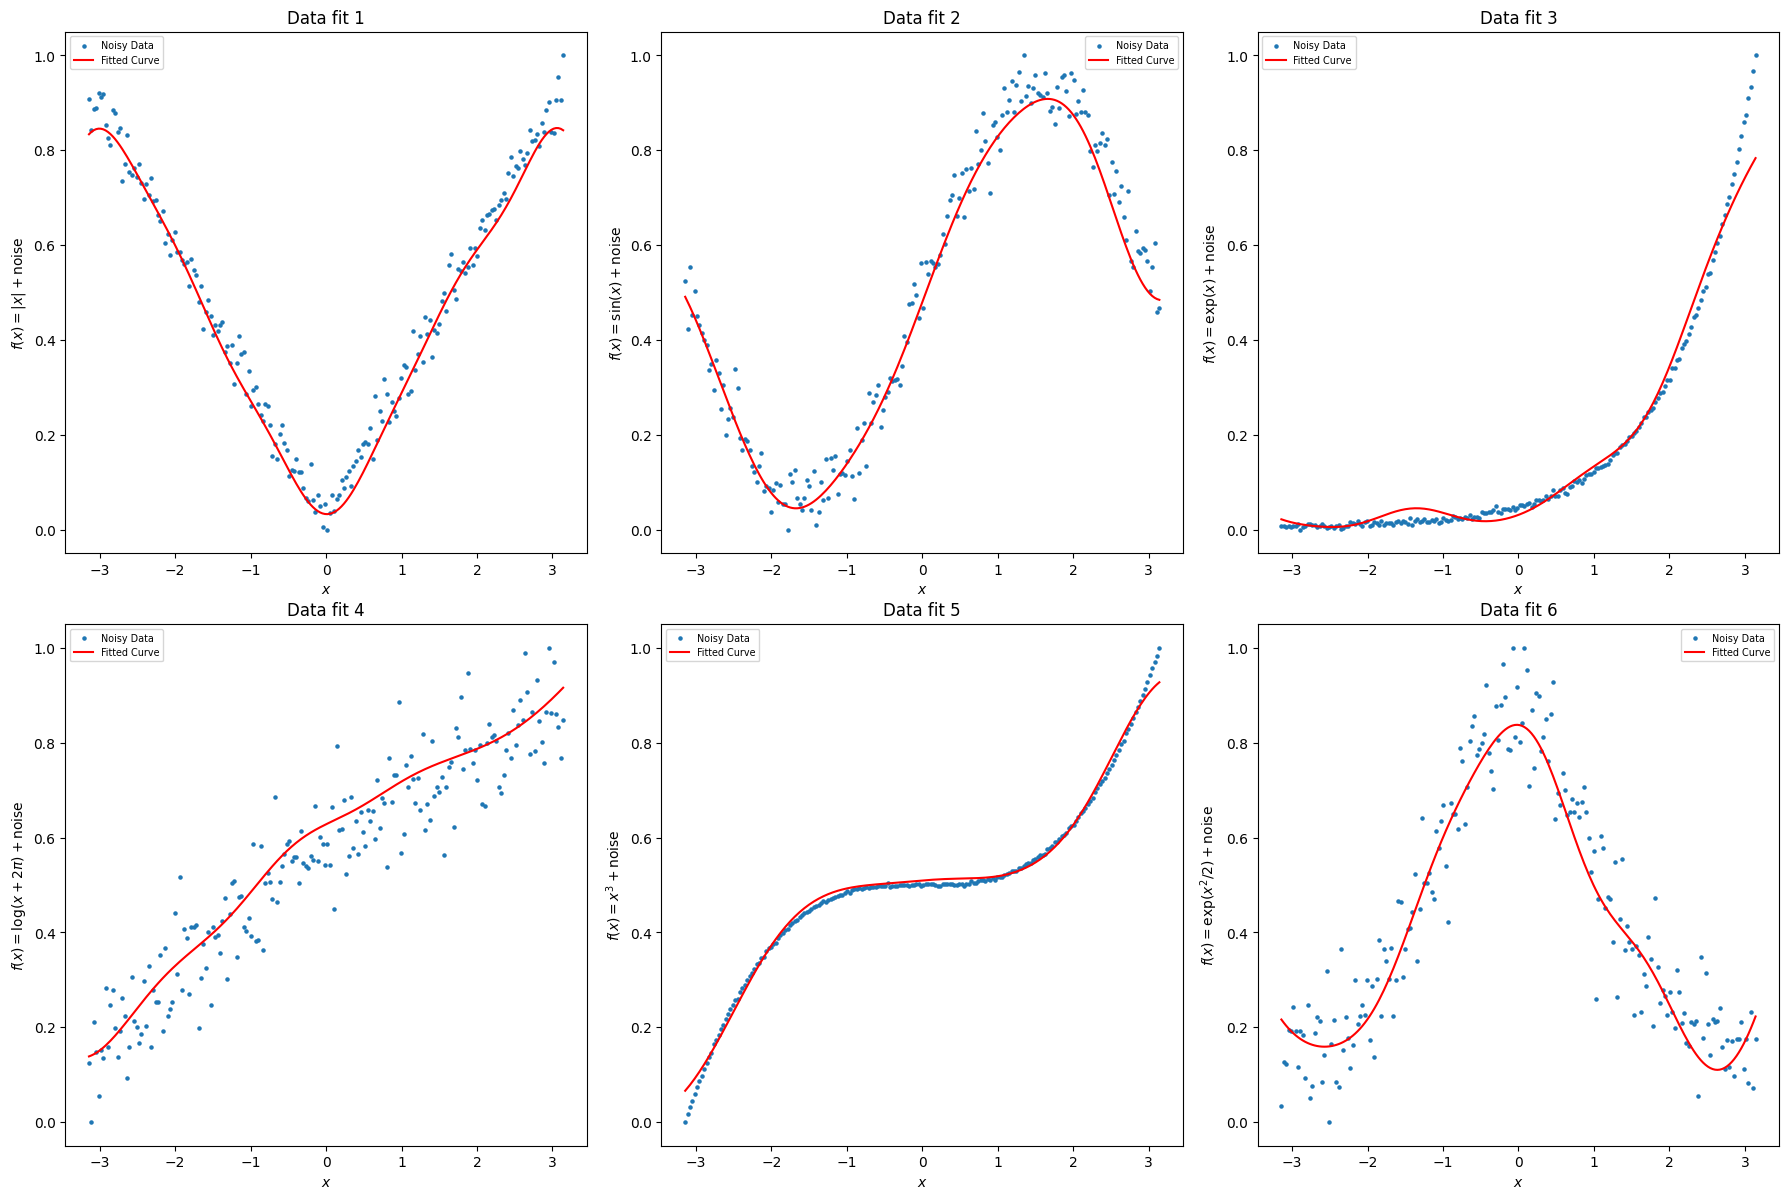

In [20]:
fit = plt.figure(figsize=(18, 12))
gs = plt.GridSpec(2, 3)

Y_preds = [model.predict(x, verbose = 0) for model in M]
y_labels = [
    r'$f(x) = |x| + \text{noise}$',
    r'$f(x) = \sin(x) + \text{noise}$',
    r'$f(x) = \exp(x) + \text{noise}$',
    r'$f(x) = \log(x+2\pi) + \text{noise}$',
    r'$f(x) = x^3 + \text{noise}$',
    r'$f(x) = \exp(x^2/2) + \text{noise}$'
]

for i in range(6):
    ax = fit.add_subplot(gs[i // 3, i % 3])
    y = Y[i]
    y_pred = Y_preds[i]
    ax.scatter(x, y, s=5, label="Noisy Data")
    ax.plot(x, y_pred, label='Fitted Curve', color='r')
    ax.set_title(f'Data fit {i+1}')
    ax.set_xlabel(r'$x$')
    ax.set_ylabel(y_labels[i])
    ax.legend(fontsize='x-small')
    ax.set_box_aspect(1)

plt.tight_layout()
fit.savefig('fits.png')
plt.show()

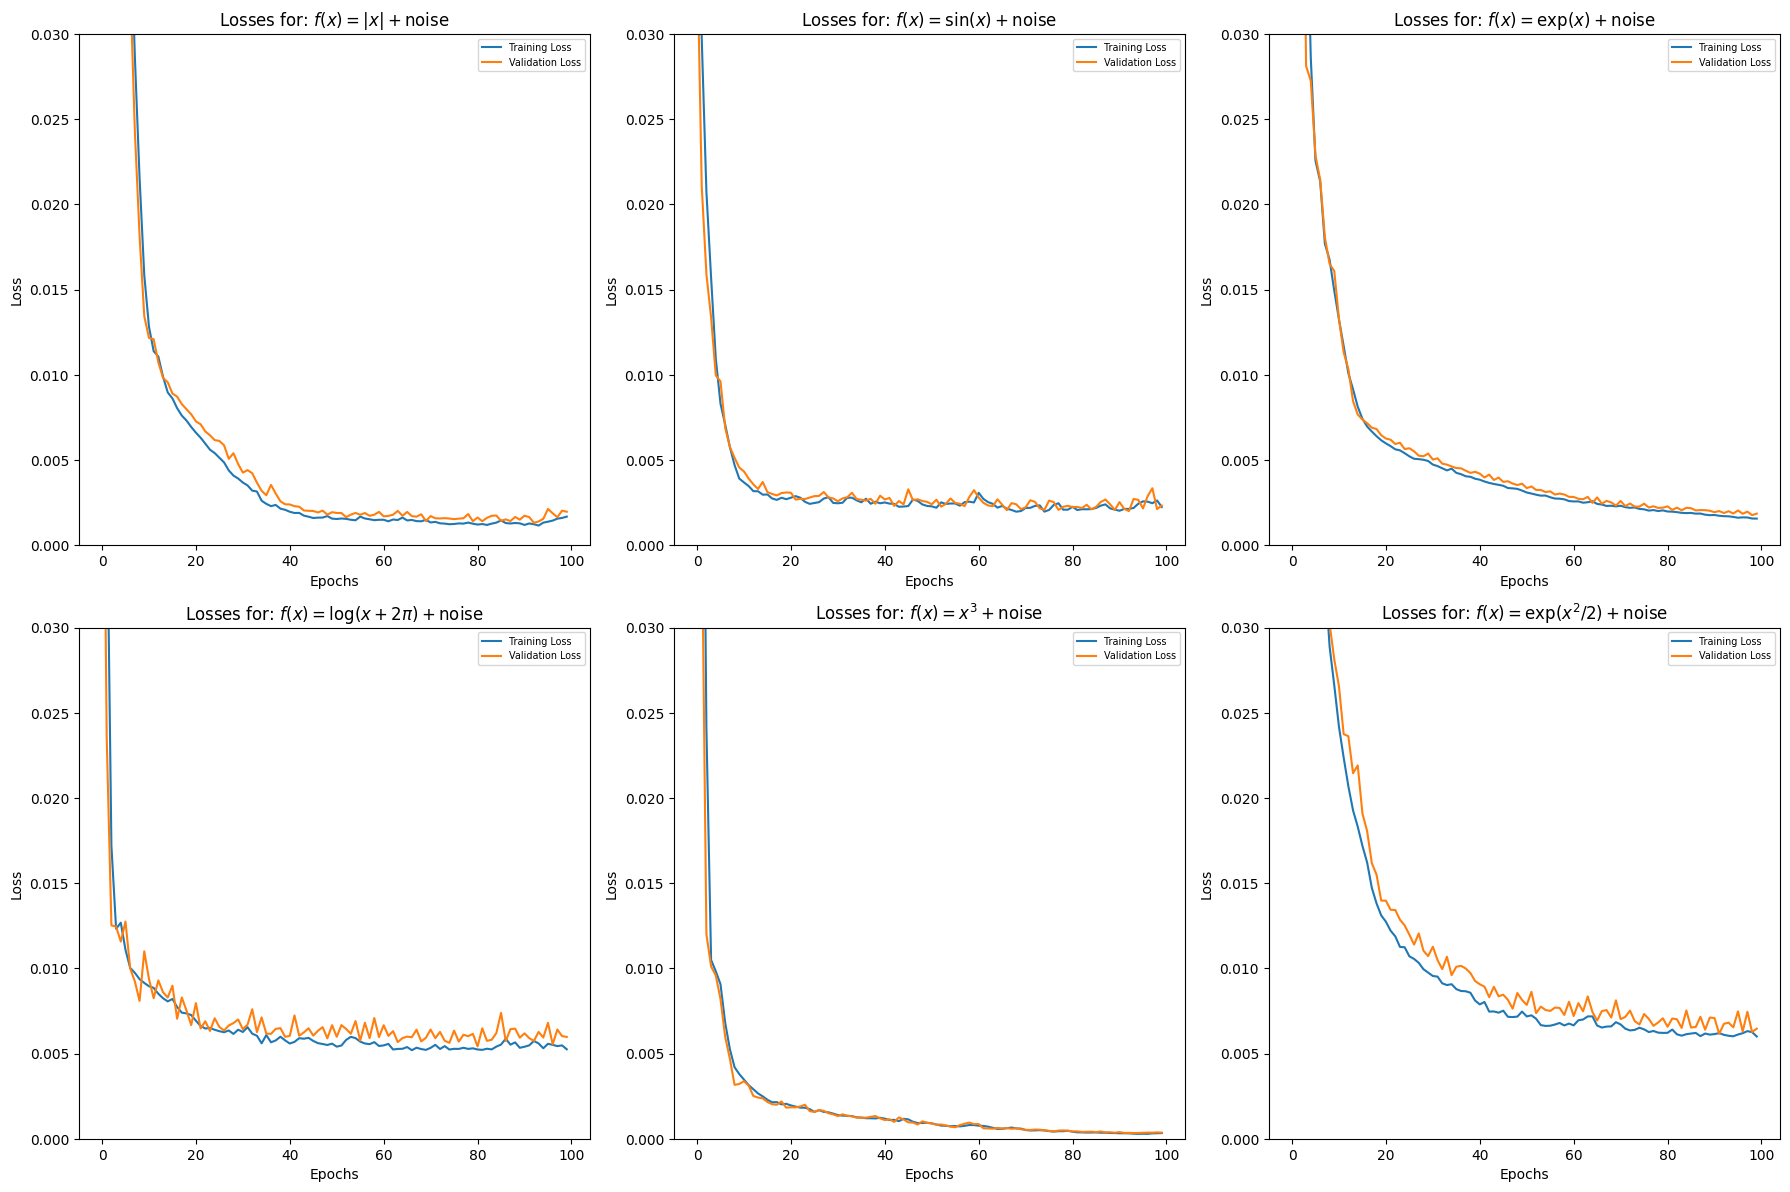

In [21]:
# Loss plot
cost = plt.figure(figsize=(18, 12))
gs = plt.GridSpec(2, 3)

for i in range(6):
    ax = plt.subplot(gs[i // 3, i % 3])
    ax.plot(H[i]['loss'], label='Training Loss')
    ax.plot(H[i]['val_loss'], label='Validation Loss')
    ax.set_title("Losses for: " + y_labels[i])
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.set_ybound(0.0, 0.03)
    ax.legend(fontsize='x-small')
    ax.set_box_aspect(1)

plt.tight_layout()
cost.savefig('mse_with_val.png')
plt.show()

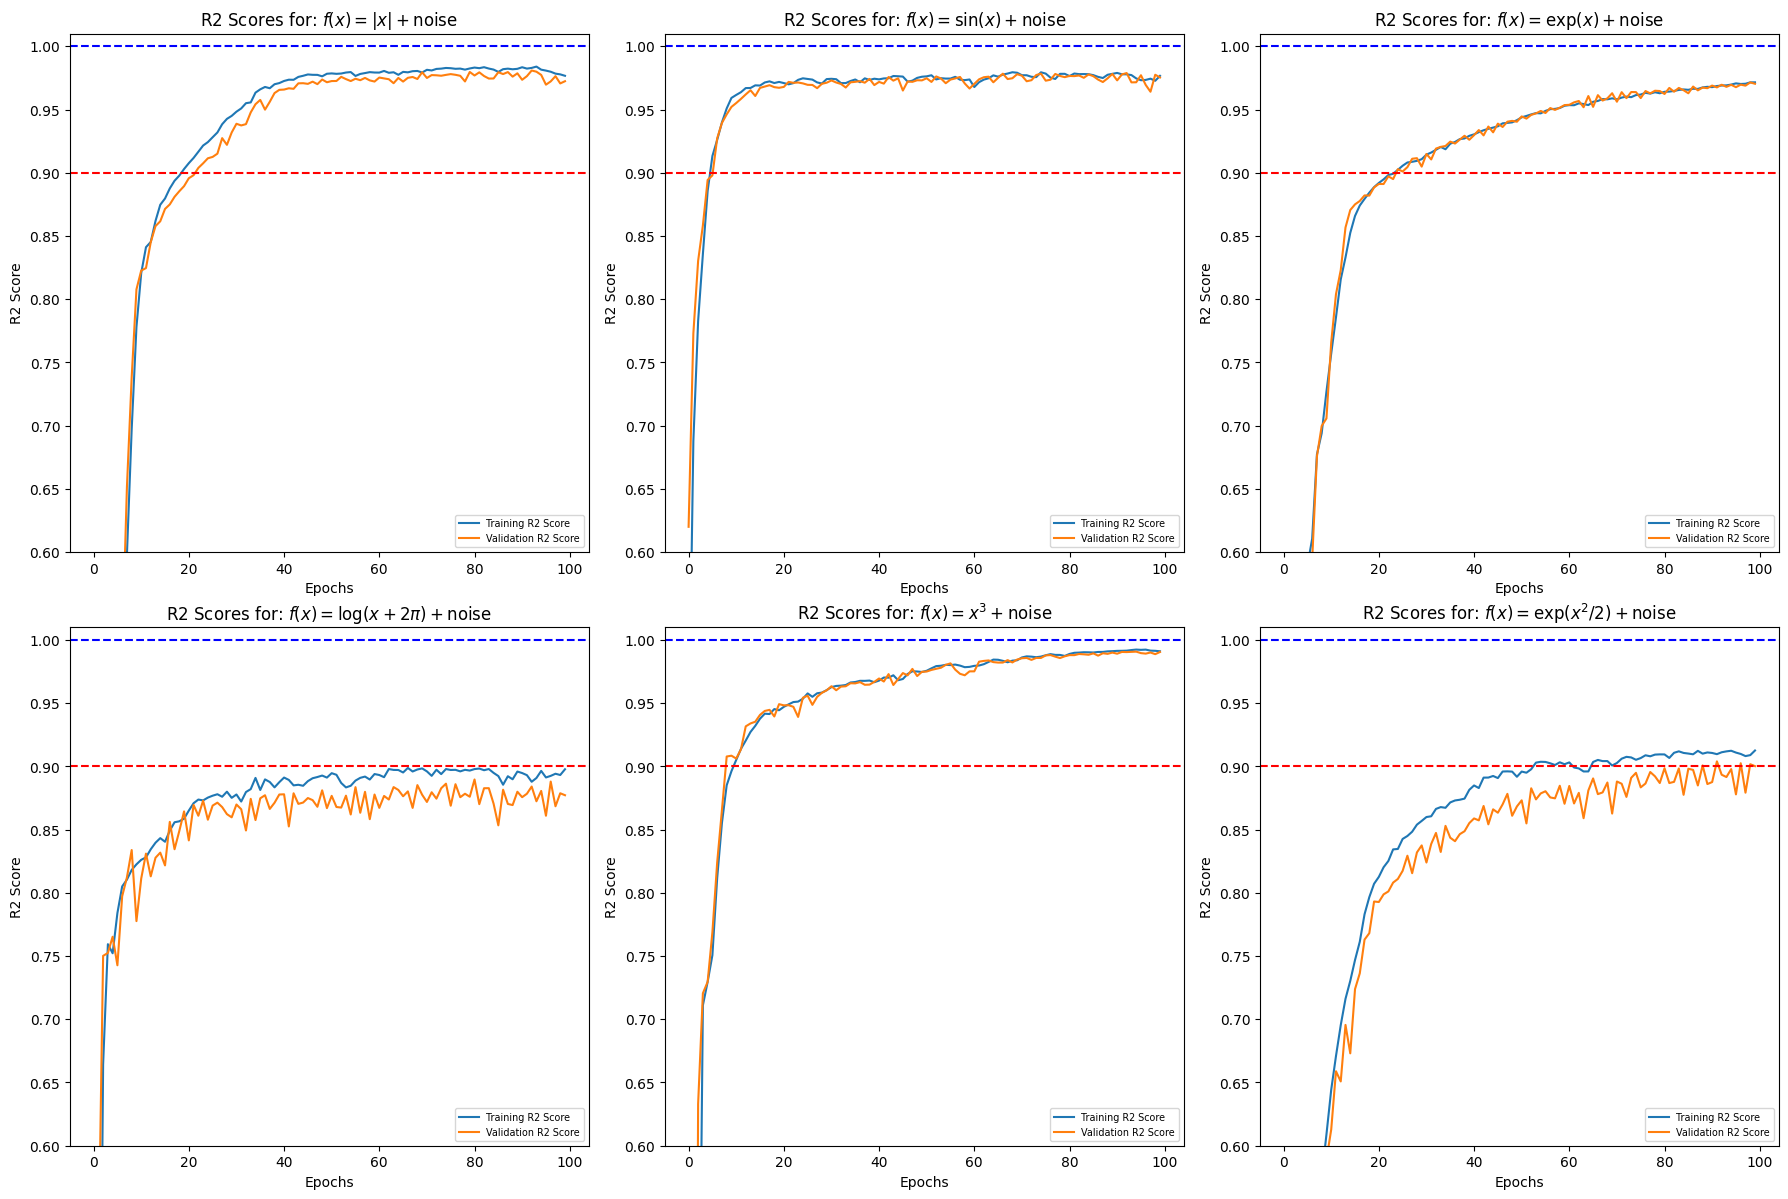

In [22]:
# R2 score plot
r2 = plt.figure(figsize=(18, 12))
gs = plt.GridSpec(2, 3)

for i in range(6):
    ax = plt.subplot(gs[i // 3, i % 3])
    ax.plot(H[i]['r2_score'], label='Training R2 Score')
    ax.plot(H[i]['val_r2_score'], label='Validation R2 Score')
    ax.set_title("R2 Scores for: " + y_labels[i])
    ax.set_xlabel('Epochs')
    ax.set_ylabel('R2 Score')
    ax.set_ybound(0.6, 1.01)
    ax.axhline(y=1.0, color='b', linestyle='--')
    ax.axhline(y=0.9, color='r', linestyle='--')
    ax.legend(fontsize='x-small')
    ax.set_box_aspect(1)

plt.tight_layout()
r2.savefig('r2_with_val.png')
plt.show()

In [18]:
# Save the history
def numpy_array_to_list(obj):
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, dict):
        return {key: numpy_array_to_list(value) for key, value in obj.items()}
    elif isinstance(obj, list):
        return [numpy_array_to_list(item) for item in obj]
    return obj

In [19]:
# Save each dictionary to a separate JSON file
for i, dictionary in enumerate(H):
    filename = f"H{i}.json"
    with open(filename, 'w') as file:
        # Convert NumPy arrays to lists before JSON serialization
        json_serializable_dict = numpy_array_to_list(dictionary)
        json.dump(json_serializable_dict, file, indent=4)

print("All dictionaries have been saved to JSON files.")

All dictionaries have been saved to JSON files.
